In [3]:
# importing relevant packages

# generic
import numpy as np
import pandas as pd

# for training models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pickling models
import joblib

# finding best model
from sklearn.model_selection import GridSearchCV, cross_val_score

# plots
import plotly.express as px

# packages for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

First we will import our preprocessed data and our target variable

In [6]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')


Now we will split the data into remainder data and testig data. We will keep the test data separate and only use it for testing purposes. 

We will train on 75% of the data and leave 25% to test on. Our test set will be a random sample stratified by velues in the target variable, y, so as to keep proportional representation of each value in y.

We will measure the success of our models by their accuracy scores on the test data.

In [7]:
# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

We will quickly check the accuracy score of a naive model that predicts the mode of y.

In [5]:
# checking proportions of each value in y
y.value_counts() / len(y) 

medical_urgency
1    0.423311
0    0.302515
2    0.274174
Name: count, dtype: float64

1 is the most common value in the target variable. A naive model that guesses 1 every time would have an accuracy of 42.33%

# Initial logistic regression model

Our first model will be a logistic regression. It will be a baseline and hopefully give us a starting point for further models and optimisation.It will be basic and will not use cross validation. Its purpose it just to light the way for future models.

Let's make our first model. We will use a pipeline that includes scaling. The parameters for the logistic regression are set more or less at random, providing starting points for future models. 

In [6]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log', LogisticRegression(C=0.1, max_iter=10000))
]

# making the pipeline
pipe = Pipeline(estimators)

Time to fit the model to the remainder set.

In [7]:
# fitting the pipeline model to the remainder data
pipe.fit(X_rem, y_rem)

Pipeline(steps=[('normalise', StandardScaler()),
                ('log', LogisticRegression(C=0.1, max_iter=10000))])

Let's pint the accuracy scores and see how the model did.

In [8]:
# printing the logistic regression model's accuracy score for the remainder set and the test set
print(pipe.score(X_rem, y_rem))
print(pipe.score(X_test, y_test))

0.7414550535094415
0.73941161643441


We have achieved 74.15% accuracy on the remainder set, and 73.94% accuracy on the test set. This is a significant imporovement on 42.33% (training accuracy) for the naive model. Hopefully we can do even better during model optimisation.

We would like to achive two things with our model. One is to accurately predict medical urgency score. The other is to determine the most influential factors to medical urgency score. The latter requires us to use a logistic regression model and to analyse the coefficients of the model. The former we can achieve by optimising over different types of models. 

We will start by optimising a logistic regression model.

Let's pickle our model so that we can access it in the future.

In [9]:
# saving the model
joblib.dump(pipe, '../model/logistic_model_1.pkl')

['../model/logistic_model_1.pkl']

In [4]:
log_reg_initial = joblib.load('../model/logistic_model_1.pkl')

In [8]:
# getting the classification report
y_pred = log_reg_initial.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.76      0.69      0.73     42006
           1       0.70      0.73      0.71     58779
           2       0.78      0.81      0.79     38070

    accuracy                           0.74    138855
   macro avg       0.75      0.74      0.74    138855
weighted avg       0.74      0.74      0.74    138855



# Optimising the logistic regression model

Including code to reload data below so it is reasy to load the same remainder and test set in case of restarting kernels. This code includes making an experimental set X_esp and y_exp to run code on to check for bugs before running models on X_rem and y_rem, which takes a lot of time. 

In [20]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')

# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# making an experimental dataframe that has 10% of the rows of X_rem
X_exp, X_bin, y_exp, y_bin = train_test_split(X_rem, y_rem, test_size=0.999, random_state=1234, stratify=y_rem)

#resetting indices
X_exp.reset_index(drop=True, inplace=True)
y_exp.reset_index(drop=True, inplace=True)

Let's set up the pipeline. We will use the l1 pentalty, since the goal of this model is to give us a sense of the most influential factors, as well as being accurate. 

In [24]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l1', max_iter=10000, solver='liblinear'))
]
pipe = Pipeline(estimators)

# setting upi values for the 'C' parameter
C = [0.01, 0.1, 1]

params = dict(
    log_reg__C = C
)

## Experimental model

First we run through the modelling and evaluation workflow with the experimental data to get the workflow working.

We will start by setting up the grid search.

In [25]:
# setting up the grid search model 
gridsearch_model_log_reg_exp = GridSearchCV(pipe, param_grid=params, cv=5)

Now let's fit the gridsearch to the experiment data.

In [26]:
# fitting the grid search model
gridsearch_model_log_reg_exp.fit(X_exp, y_exp)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1]})

Now we find the accuracy of the best model.

In [27]:
# finding the accuracy of the best experimental model
gridsearch_model_log_reg_exp.score(X_test, y_test)

0.6192574988297145

Even with such a small training set we were still able to achieve 62% accuracy! This bodes well for when we use the whole dataset. This is significantly better than a naive model that guesses class 1 every time. 

Let's pickle the gridsearch for future reference.

In [39]:
# pickling the gridsearch model
joblib.dump(gridsearch_model_log_reg_exp, '../model/logistic_model_2_gridsearch_exp.pkl')

['../model/logistic_model_2_gridsearch_exp.pkl']

In [40]:
# loading the gridsearch model
log_reg_model_exp = joblib.load('../model/logistic_model_2_gridsearch_exp.pkl')

In [ ]:
# getting the classification report
y_pred = log_reg_initial.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

#### Evaluation

Lets get the confusion matirx first.

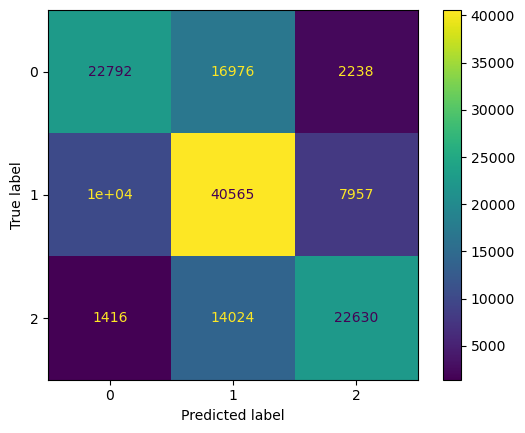

In [30]:
# getting a heatmap of the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model_exp, X_test, y_test)

Now to get the classification report to check the recall and precision scores.

In [31]:
# getting the classification report
y_pred = log_reg_model_exp.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.66      0.54      0.60     42006
           1       0.57      0.69      0.62     58779
           2       0.69      0.59      0.64     38070

    accuracy                           0.62    138855
   macro avg       0.64      0.61      0.62    138855
weighted avg       0.63      0.62      0.62    138855



We won't analyse these as the model is just for the experimental data. 

#### Influential factors

Now we will set up a dataframe that contains the most inflential factors in predicting class 0, which we will deem the most important class to predict, since anyone given a medical urgency score of 0 is in most need of medical care. 

In [32]:
# setting up a series to plot most influential factors in predicting class 0
most_inf_0_pos = pd.DataFrame(log_reg_model_exp.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).head(5)
most_inf_0_neg = pd.DataFrame(log_reg_model_exp.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).tail(5)
most_inf = pd.DataFrame(pd.concat([most_inf_2_pos, most_inf_2_neg]))
most_inf.reset_index(inplace=True)

# renaming columns and adding an effect column that will aid in visualisation
most_inf.rename(columns={'index': 'Attribute', 0: 'Odds ratio multiplier class 0'}, inplace=True)
most_inf['Effect'] = 'none'


We will define a function that makes the 'Effect' column in the dataframe of influential factors 'positive' if increasing that variable results in an increase in odds ratio of getting class 0, and 'negative if the opposite is true. It will mean we can colour the attributes that hacve a negative influence a different colour to those that have a positive influence.

In [33]:
# defining the function described above
def sign(mult):
    if mult > 0:
        return('positive')
    else:
        return('negative')

Now let's apply the function.

In [34]:
# appying the function to the 'Effect' column
most_inf['Effect'] = most_inf['Odds ratio multiplier class 0'].apply(sign)

Now that we have the dataframe of influential factors as desired, we are ready to plot the factors in a bar chart.

In [35]:
# plotting the bar chart
fig = px.bar(most_inf, x='Odds ratio multiplier class 0', y='Attribute', orientation='h', color='Effect')
fig.update_layout(title_text='Most influential factors in predicting medical urgency', title_x=0.5)
fig.show()

We won't read too much into this now, as the results are just on the experimental data. We will go into the details when we run the model on the remainder set.

## Real model

In [36]:
# setting up the grid search model 
gridsearch_model_log_reg_opt = GridSearchCV(pipe, param_grid=params, cv=5)


In [37]:
# fitting the girsearch
gridsearch_model_log_reg_opt.fit(X_rem, y_rem)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1]})

In [41]:
# saving the gridsearch
joblib.dump(gridsearch_model_log_reg_opt, '../model/logistic_model_3_gridsearch_rem.pkl')

['../model/logistic_model_3_gridsearch_rem.pkl']

In [9]:
# loading the optimised model
log_reg_model_opt_rem = joblib.load('../model/logistic_model_3_gridsearch_rem.pkl')

In [47]:
# getting best parameters of the optimisation
log_reg_model_opt_rem.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    solver='liblinear'))])

The best C value is 0.1. Let's see how accurate the model is.

In [45]:
# finding the accuracy of the best experimental model
log_reg_model_opt_rem.score(X_test, y_test)

0.7333261315761046

We have achieved a test accuracy of 73.33%. This is a bit dissapointing, as it is a little worse than our initla logistic regression model that used the l2 penalty with the 'lbfgs' solver. 

We will now proceed to evaluate and draw insights from the inital logistic regression model, since it was our best performing one. We may use the best model with the l1 penalty to select features to run different models with, but since for now we are only going to look at the top 5 most influential positive and negative factors, we will just analyse the model with the l2 penalty function. 

In [10]:
# getting the classification report
y_pred = log_reg_model_opt_rem.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.75      0.70      0.72     42006
           1       0.70      0.71      0.70     58779
           2       0.77      0.81      0.79     38070

    accuracy                           0.73    138855
   macro avg       0.74      0.74      0.74    138855
weighted avg       0.73      0.73      0.73    138855



## Best logistic model evaluation and insights

Let's load the model.

In [48]:
# loading the best model
log_reg_model_best = joblib.load('../model/logistic_model_1.pkl')

#### Evaluation

Let's have a look at the classification report.

In [ ]:
# getting the classification report
y_pred = log_reg_model_best.predict(X_test)
class_report = classification_report(y_test, y_pred)

# printing the classification report
print(class_report)

              precision    recall  f1-score   support

           0       0.76      0.69      0.73     42006
           1       0.70      0.73      0.71     58779
           2       0.78      0.81      0.79     38070

    accuracy                           0.74    138855
   macro avg       0.75      0.74      0.74    138855
weighted avg       0.74      0.74      0.74    138855



The accuracy is 74%, which is much better than a naive model (42%). 

The recall for class 0 seems to be one of the more important measures, since miss-classifying a patient who should be in class 0 is potentially life threatrening, as they may not receive the medical attention appropriate for their condition. The recall for class 0 is 69%, which is ok, but it is the lowest of all the precision and recall scores. It may be worth having future models prioritise correctly diagnosing class 0 cases. 

It is interesting to see that class 2 has the highest precision and recall scores (78% and 81% respectively). It is hard to say exactly why this would be, especially since it is the class with the fewest datapoints. It may be down to the fact that someone in classes 1 or 0 are there because of factors that are not 'standard' medical factors, and so are not in our feature columns. They may also be more dependent on the feature variables that we got rid of in our null value cleaning. It might be worth revisiting that decision.

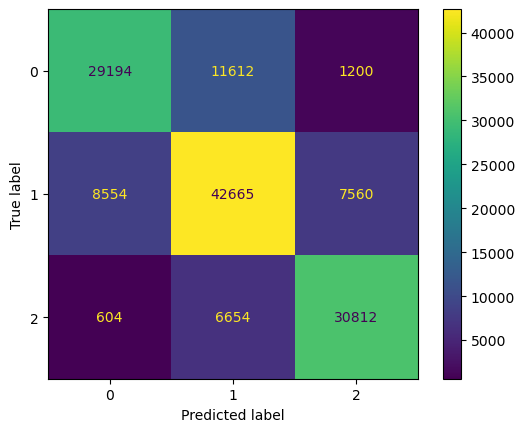

In [49]:
# getting a heatmap of the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model_best, X_test, y_test)

This provides a visual aid to the classification report and provides insights into which classes we are mis classifying each class as. The model mainly misclassifies class 0 cases as class 1, which makes sense. Similarly, the model misclassifies class 2 casses as class 1 much more than as class 0. Class 1 is missclassified as class 0 roughly the same as it is misclassified as class 1. These results make intuitive sense, as it probably similar to how a human would missclassify cases. 

The model guesses the class correctly most frequenty with class 1, which aligns with the fact that class 1 is the most frequent class in our dataset.

As discussed above in the classification report, it is more life threatening to misclassify class 0 as class 1 or 2. But it is also costly to misclassify class 2 as class 1 or 0, since, in practise, more resources would be used on a patient in class 0, which may be unnecessary if they are actually in class 2. If a model like this were to be implemented, a compromise would probably have to be reached between the misclassifications, based on availabel resources of the hospital and making sure that patients get the medical attention they need.

#### Influential factors

Let's set up the bar chart as in the experimental workflow.

In [67]:
# setting up a series to plot most influential factors in predicting class 0
most_inf_0_pos = pd.DataFrame(log_reg_model_best['log'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).head(5)
most_inf_0_neg = pd.DataFrame(log_reg_model_best['log'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False).tail(5)
most_inf = pd.DataFrame(pd.concat([most_inf_0_pos, most_inf_0_neg]))
most_inf.reset_index(inplace=True)

# renaming columns and adding an effect column that will aid in visualisation
most_inf.rename(columns={'index': 'Attribute', 0: 'Odds ratio multiplier class 0'}, inplace=True)
most_inf['Effect'] = 'none'


In [68]:
# appying the function to the 'Effect' column
most_inf['Effect'] = most_inf['Odds ratio multiplier class 0'].apply(sign)

In [71]:
# plotting the bar chart
fig = px.bar(most_inf, x='Odds ratio multiplier class 0', y='Attribute', orientation='h', color='Effect')
fig.update_layout(title_text='Most influential factors in predicting medical urgency', title_x=0.5)
fig.show()

Before analysing the chart, we need to look at which variables the 'get_dummies' function got rid of, as we will  need to compare some of the influential variables with them. The code finding these can be found in the preprossing notebook. We will just print them here:

'arrivalday_Friday',
 'arrivalhour_bin_03-06',
 'arrivalmode_Car',
 'arrivalmonth_April',
 'dep_name_A',
 'employstatus_Disabled',
 'ethnicity_Hispanic or Latino',
 'gender_Female',
 'insurance_status_Commercial',
 'lang_English',
 'maritalstatus_Civil Union',
 'previousdispo_AMA',
 'race_American Indian or Alaska Native',
 'religion_Baptist'

Positive factors:

The most influential positive factors are quite revealing, and not entirely surprising (also a little sobering....). The most inflential factor in predicting class 0 in the model is 'cc_suicidal' - chief complaint suicidal. The fourth is psychiatric evaluation. These indicate that mental health is a very significant factor in classifying a patient as in urgent need of medical attention.

Chest pain is also very influential, which makes sense since it can often be a symptom of something dangerous. 'cc_strokealert' is also unsurprising, since it is a very diagnosable and dangerous condition. 

'cc_alcoholicintoxication' ranks as the third most influential positive factor. Again, this is not very surprising, alchol can be very dangerous and if someone is going to the emergency department because of alcohol, it is probabaly quite easy to diagnose them with alcohol poisoning, which is severe and requires fast medical attention. 

Negative factors:

It is interesting, though not completely unsurprising that kneepain and backpain are in the top five most influential negative factors. The are both things that often (unless in very serious cases that might be casued by a motorcrash, for example) are not life threatening.  It is difficult to interpret the department names being in here. The results indicate that going to departments B or C decrease your odds ratio of being in class 0, compared with going to department A. This could mean that department A is the department you go to when you are obviously in serious need of medical attention, or similarly that department A is the department that ambulances go to.

'arrivalmode_Unknown' being here indicates that it decreases odds ratio of being classified as class 0, compared to arriving by car. It is not immediately obvious why this might be the case. It may be that patients in urgent need of care would get there as quickly as possible (car or ambulance for example) and drive straight to the front, making their arrival mode known.

#### Conclusion

We have a good working model that outperforms a naive model by a significant margin. The models we have made here will be useful in guiding decisions about future models, and we can use the factor influence analysis to help decide which featire variables to use in models whose purpose it is to classify cases using fewer variables. 